# Assignment 11  - Monte Carlo


## Authors
B.W. Holwerda

## Learning Goals
* What is Monte Carlo?
* How to use Monte Carlo techniques
* Using the numpy random module

## Keywords
python, syntax, jupyter notebook, matplotlib, numpy random, monte carlo

## Companion Content

## Summary

This is an introduction to the Monte Carlo technique based on the first example in the lab here: https://openbooks.library.umass.edu/p132-lab-manual/chapter/introduction-to-mc/
With some of the bugs fixed and translated into an original jupyter notebook. 

<hr>




based on: 

https://levelup.gitconnected.com/create-your-own-metropolis-hastings-markov-chain-monte-carlo-algorithm-for-bayesian-inference-with-fbabc3f01baa

code on github:
https://github.com/pmocz/mcmc-python

## Student Name and ID:



## Date:

<hr>

# Exoplanets from radial movements.

We will work out a concrete example of the Metropolis-Hastings MCMC being used to fit a (mock) dataset of exoplanet radial velocity measurements to recover the orbital parameters of the model.

A telescope measures the ‘wobble’ (radial velocity) of a star, due to an exoplanet orbiting it. This radial velocity v(t) measured at several points in time, t, depends on the orbital parameters:

$$ v(t) = V - K [sin(f(t,e,P,\chi)+\varpi) + e sin(\varpi)]$$

where

* $f(t,e,P,\chi)$ is the true anomaly at time t 
* K is the velocity semi-amplitude of the planet
* $e$ is the orbital eccentricity of the planet
* $\varpi$ is the longitude of the periastron (nearest point from the star in the planet's orbit)
* $\chi$ is the time of periastron
* $P$ is the orbital period
* $V$ is the systemic velocity of the whole stellar system.

We will generate data-sets for a hypothetical star+exoplanet system and employ MCMC to constrain the values for these variables. 

# Bayesian Framework

We will use a Bayesian framework for model fitting and parameter estimation. Supposing a model with a set of parameters $\theta$ (this the the collection of model variables) and given a dataset $D$, we need to find the posterior distribution $P(θ|D)$ for the model parameters using Bayes Theorem:

$$ P(\theta | D) = {P(D|\theta) P(\theta) \over P(D)} $$

where

* $P(\theta | D)$ is the **posterior** probability for the parameters to have a value $\theta$, given the data $D$ are true.
* $P(D|\theta)$ is the **likelihood** of the data $D$, assuming the set of parameters $\theta$ is true.
* $P(\theta)$ is the **prior** probability that a set of parameters $\theta$ is true (before seeing any data).
* $P(D)$ is the **marginalization**, i.e. the probability of data $D$ being true.



# Metropolis-Hastings Markov Chain Monte Carlo

The Metropolis-Hastings MCMC algorithm will randomly sample the posterior distribution. A Markov Chain is a stochastic process where each state in the chain only depends on the previous state. The algorithm will:

* Draw a random value for $\theta$ from the prior distribution, $\theta_{prev}$

* For i = 1 … N, where N is the length of the Markov Chain:

    * Propose a new value $\theta_{prop}$ to add to the chain, by adding a random perturbation to $\theta_{prev}$ using a proposal distribution

    * Evaluate the posterior probabilities $P_{prop}$ and $P_{prev}$ of the parameters $\theta_{prop}$ and $\theta_{prev}$

    * Draw a random number $U$ from a uniform distribution between 0 and 1 (this is the random in random walk)

    * If $U < min(1, P_{prop}/P_{prev})$ then add $\theta_{prop}$ to the Markov chain and set $\theta_{prev}=\theta_{prop}$, else add (another copy of) $\theta_{prev}$ to the chain.

* Cut off the beginning of the chain (the ‘burn-in’ region) where the model parameters are far from being a good fit.

This is happening in the for loop over range(N) below.


The prior distribution may, for example, be a uniform distribution with a min and max value, if not much is known about the parameters. This is where much of prior knowledge of physics can help set limits on our model, e.g. no speeds over the speed of light or the escape velocity of the star's gravity (wouldn't be an orbit otherwise). 

The proposal distribution (in the ‘propose()’ function) is a random perturbation that is added to each parameter, as a way to traverse the parameter space. This is the ``let's try this'' of the model.


For example, the perturbation step can be a random value drawn from a Gaussian. The important thing to set in that case is the standard deviation of the Gaussian. In essence how big a step is allowed for the model. Too big and it will never converge, too small and it will run forever.

It makes sense for the perturbation to not be too large or too small, so in this example, we set it to be 2% of the parameter range. The exact step size does not matter too much (computers can do this a lot), but it can affect the proposal accept/reject rate in the MCMC algorithm. 

If the parameters are bounded (we have set priors and limits) then we also need to treat the case of what happens if a proposed set of parameters $\theta_{prop}$ is out of bounds; in such a case, we can reflect the value across the boundary to be back in bounds.



# Posteriors

Finally, at the heart of the algorithm is the calculation of the posterior. And the most important part of that step is the calculation of the likelihood, which depends on the model and parameters you are fitting (more on this in the next section). Since all that matters in the MCMC algorithm is the ratio of posteriors Pprop/Pprev, we do not need to calculate the marginalization P(D) because it cancels in the ratio. Additionally, if the priors are uniform/flat, we can ignore calculating those too because they also cancel.


In [31]:
# loading in what we need matplotlib, numpy and several functions to do MCMC with

import matplotlib.pyplot as plt
import numpy as np
from mcmc import *


from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150
rcParams["font.size"] = 15



# MCMC Functions

in the MCMC python file, there are some functions defined for use in the MCMC

* rv_model( V, K, w, e, P, chi, t )

    * Calculate the radial velocity curve of exoplanet system
    * V      systemic velocity
    * K      velocity semiamplitude
    * w      longitude of periastron
    * e      eccentricity
    * P      orbital period
    * chi    fraction of an orbit, prior to t=0, at which periastron occured
    * t      array of times to output radial velocities
* log_prior(theta, theta_lo, theta_hi)

    * Calculate the log of the priors for a set of parameters 'theta'
    * We assume uniform priors bounded by 'theta_lo' and 'theta_hi'

* propose(theta_prev, sigma_theta, theta_lo, theta_hi):
    * propose a new set of parameters 'theta' given the previous value
    'theta_prev' in the Markov chain. Choose new values by adding a 
    random Gaussian peturbation with standard deviation 'sigma_theta'.
    Make sure the new proposed value is bounded between 'theta_lo'
    and 'theta_hi'

* eval_model(theta, t):
	
    * Evaluate the RV model given parameters 'theta' at times 't'

* log_likelihood(rv_pred, s, rv_data, rv_errors):
	
    * Evaluate the log likelihood of a model 'rv_pred' given the data
    
* log_posterior(theta, t, rv_data, rv_errors):
	
    * Evaluate the log posterior of a model parameters 'theta' given the data
    Note: since our priors are constant, we ignore adding it

/Users/benneholwerda/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp


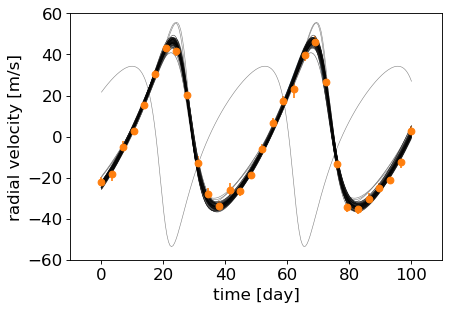

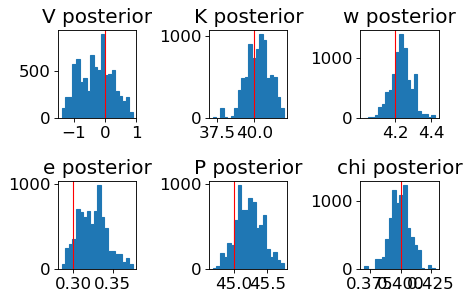

0

In [35]:
def fitmcmc():
    """ Fit Radial Velocity curve parameters with MCMC """

    # set the random number generator seed
    np.random.seed(917)

    # Generate Mock Data
    N_params = 7
    V   = 0.0     # systemic velocity
    s   = 1.0     # stellar jitter (Gaussian error)
    K   = 40.0    # velocity semiamplitude
    w   = 4.2     # longitude of periastron
    e   = 0.3     # eccentricity
    P   = 45.0    # orbital period
    chi = 0.4     # fraction of an orbit, prior to t=0, at which periastron occured

    t_max = 100.0
    t  = np.linspace(0, t_max,  30)  # array of times
    tt = np.linspace(0, t_max, 200)  # dense array of times

    # array of Gaussian measurement errors at each time
    rv_errors = 2.0 + np.abs(np.random.normal(0.0, 1.0, size=t.size))	
    
    # exact radial velocity curve, for plotting
    rv_exact = rv_model( V, K, w, e, P, chi, tt)
    
    # mock data set (30 points)
    rv_data  = rv_model( V, K, w, e, P, chi, t) 
    for i in range(len(t)):
        rv_data[i] += np.random.normal(0.0,np.sqrt(s**2 + rv_errors[i]**2))

    # Bounds on Priors
    V_bounds   = np.array([-4.0,      4.0])
    s_bounds   = np.array([0.5,       1.2])
    K_bounds   = np.array([20.0,     60.0])
    w_bounds   = np.array([0.0, 2.0*np.pi])
    e_bounds   = np.array([0.0,       0.5])
    P_bounds   = np.array([30.0,     50.0])
    chi_bounds = np.array([0.0,       1.0])
    
    theta_bounds = np.array([V_bounds, s_bounds, K_bounds, w_bounds, e_bounds, P_bounds, chi_bounds])
    theta_lo = theta_bounds[:,0]
    theta_hi = theta_bounds[:,1]

    sigma_theta = 0.02 * (theta_hi - theta_lo)

    # prep figure
    fig = plt.figure(figsize=(6,4), dpi=80)

    # plot exact rv curve and mock data
    plt.plot(tt, rv_exact)
    plt.errorbar(t, rv_data, rv_errors, fmt='o')
    plt.xlabel("time [day]")
    plt.ylabel("radial velocity [m/s]")
    plt.xlim([-10,t_max+10])
    plt.ylim([-60, 60])

    # Carry out MCMC fitting to get best-fit parameters	
    Nburnin = 1000
    N = 8000 + Nburnin
    theta = np.zeros((N,N_params))
    
    theta_prev = np.random.uniform(theta_lo, theta_hi)

    for i in range(N):
        # take random step using the proposal distribution
        theta_prop = propose(theta_prev, sigma_theta, theta_lo, theta_hi)

        P_prop = log_posterior(theta_prop, t, rv_data, rv_errors)
        P_prev = log_posterior(theta_prev, t, rv_data, rv_errors)

        U = np.random.uniform(0.0, 1.0)
        r = np.min([1.0, np.exp(P_prop-P_prev)])
    
        if (U <= r):
            theta[i,:] = theta_prop
            theta_prev = theta_prop
        else:
            theta[i,:] = theta_prev

        # plot proposed function
        if (i % 100) == 0:
            # print(theta[i,:])
            rv = eval_model(theta[i,:], tt)
            c = (1.0 - i/N)*0.5
            plt.plot(tt, rv, linewidth=0.5, color=(c,c,c))
            # plt.pause(0.0001)

    # Save figure
    plt.savefig('mcmc.png',dpi=240)
    plt.show()

    # cut off burnin
    theta = theta[Nburnin:,:]

    # Plot Posteriors

    fig, ((ax0, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(6,4), dpi=80)

    n_bins = 20
    ax0.hist(theta[:,0], n_bins, histtype='step', fill=True)
    ax0.axvline(V, color='r', linewidth=1)
    ax0.set_title('V posterior')
    ax2.hist(theta[:,2], n_bins, histtype='step', fill=True)
    ax2.axvline(K, color='r', linewidth=1)
    ax2.set_title('K posterior')
    ax3.hist(theta[:,3], n_bins, histtype='step', fill=True)
    ax3.axvline(w, color='r', linewidth=1)
    ax3.set_title('w posterior')
    ax4.hist(theta[:,4], n_bins, histtype='step', fill=True)
    ax4.axvline(e, color='r', linewidth=1)
    ax4.set_title('e posterior')
    ax5.hist(theta[:,5], n_bins, histtype='step', fill=True)
    ax5.axvline(P, color='r', linewidth=1)
    ax5.set_title('P posterior')
    ax6.hist(theta[:,6], n_bins, histtype='step', fill=True)
    ax6.axvline(chi, color='r', linewidth=1)
    ax6.set_title('chi posterior')

    fig.tight_layout()

    # Save figure
    plt.savefig('mcmc2.png',dpi=240)
    plt.show()
    
    return 0



fitmcmc()

### Exercise 1 - Parameters

How many parameters are there for the model?

*student answer here*

### Exercise 2 - Bounds

How are the bounds for the parameters set? Relative to the initial values or absolute?

*student answer here*

### Exercise 3 - Modifying parameters

change the values of some of the parameters. How does the fit change? Do the bounds on the parameters still make sense?

*student answer here*

### Exercise 4 - Modify MCMC

Make a modified version of the fitmcmc function below that allows for easy different starting parameters and bounds. 

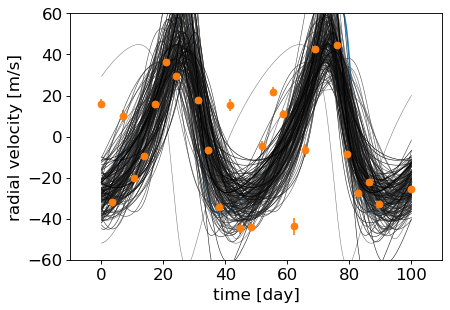

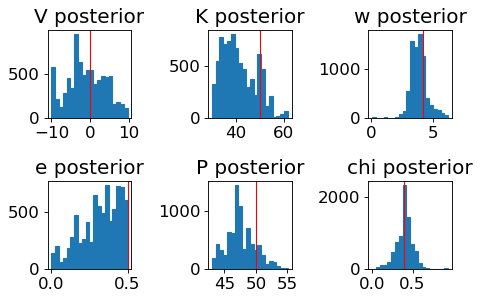

0

In [34]:
# student work here

def fitmcmc(V,s,K,w,e,P,chi,Ndata=30,Nburnin=1000):
    """ Fit Radial Velocity curve parameters with MCMC """

    # set the random number generator seed
    np.random.seed(917)

    # Generate Mock Data
    N_params = 7
    #V   = 0.0     # systemic velocity
    #s   = 1.0     # stellar jitter (Gaussian error)
    #K   = 40.0    # velocity semiamplitude
    #w   = 4.2     # longitude of periastron
    #e   = 0.3     # eccentricity
    #P   = 45.0    # orbital period
    #chi = 0.4     # fraction of an orbit, prior to t=0, at which periastron occured

    t_max = 100.0
    t  = np.linspace(0, t_max,  Ndata)  # array of times
    tt = np.linspace(0, t_max, 200)  # dense array of times

    # array of Gaussian measurement errors at each time
    rv_errors = 2.0 + np.abs(np.random.normal(0.0, 1.0, size=t.size))	
    
    # exact radial velocity curve, for plotting
    rv_exact = rv_model( V, K, w, e, P, chi, tt)
    
    # mock data set (30 points)
    rv_data  = rv_model( V, K, w, e, P, chi, t) 
    for i in range(len(t)):
        rv_data[i] += np.random.normal(0.0,np.sqrt(s**2 + rv_errors[i]**2))

    # Bounds on Priors
    V_bounds   = np.array([V-10.0,      V+10.0])
    s_bounds   = np.array([0.5*s,       1.5*s])
    K_bounds   = np.array([K-20,        K+20])
    w_bounds   = np.array([0.0,         2.0*np.pi])
    e_bounds   = np.array([0.0,         0.5])
    P_bounds   = np.array([P-7,         P+7])
    chi_bounds = np.array([0.0,         1.0])
    
    theta_bounds = np.array([V_bounds, s_bounds, K_bounds, w_bounds, e_bounds, P_bounds, chi_bounds])
    theta_lo = theta_bounds[:,0]
    theta_hi = theta_bounds[:,1]

    sigma_theta = 0.02 * (theta_hi - theta_lo)

    # prep figure
    fig = plt.figure(figsize=(6,4), dpi=80)

    # plot exact rv curve and mock data
    plt.plot(tt, rv_exact)
    plt.errorbar(t, rv_data, rv_errors, fmt='o')
    plt.xlabel("time [day]")
    plt.ylabel("radial velocity [m/s]")
    plt.xlim([-10,t_max+10])
    plt.ylim([-60, 60])

    # Carry out MCMC fitting to get best-fit parameters	
    # Nburnin = 1000
    N = 8000 + Nburnin
    theta = np.zeros((N,N_params))
    
    theta_prev = np.random.uniform(theta_lo, theta_hi)

    for i in range(N):
        # take random step using the proposal distribution
        theta_prop = propose(theta_prev, sigma_theta, theta_lo, theta_hi)

        P_prop = log_posterior(theta_prop, t, rv_data, rv_errors)
        P_prev = log_posterior(theta_prev, t, rv_data, rv_errors)

        U = np.random.uniform(0.0, 1.0)
        r = np.min([1.0, np.exp(P_prop-P_prev)])
    
        if (U <= r):
            theta[i,:] = theta_prop
            theta_prev = theta_prop
        else:
            theta[i,:] = theta_prev

        # plot proposed function
        if (i % 100) == 0:
            # print(theta[i,:])
            rv = eval_model(theta[i,:], tt)
            c = (1.0 - i/N)*0.5
            plt.plot(tt, rv, linewidth=0.5, color=(c,c,c))
            # plt.pause(0.0001)

    # Save figure
    plt.savefig('mcmc.png',dpi=240)
    plt.show()

    # cut off burnin
    theta = theta[Nburnin:,:]

    # Plot Posteriors

    fig, ((ax0, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(6,4), dpi=80)

    n_bins = 20
    ax0.hist(theta[:,0], n_bins, histtype='step', fill=True)
    ax0.axvline(V, color='r', linewidth=1)
    ax0.set_title('V posterior')
    ax2.hist(theta[:,2], n_bins, histtype='step', fill=True)
    ax2.axvline(K, color='r', linewidth=1)
    ax2.set_title('K posterior')
    ax3.hist(theta[:,3], n_bins, histtype='step', fill=True)
    ax3.axvline(w, color='r', linewidth=1)
    ax3.set_title('w posterior')
    ax4.hist(theta[:,4], n_bins, histtype='step', fill=True)
    ax4.axvline(e, color='r', linewidth=1)
    ax4.set_title('e posterior')
    ax5.hist(theta[:,5], n_bins, histtype='step', fill=True)
    ax5.axvline(P, color='r', linewidth=1)
    ax5.set_title('P posterior')
    ax6.hist(theta[:,6], n_bins, histtype='step', fill=True)
    ax6.axvline(chi, color='r', linewidth=1)
    ax6.set_title('chi posterior')

    fig.tight_layout()

    # Save figure
    plt.savefig('mcmc2.png',dpi=240)
    plt.show()
    
    return 0



fitmcmc(V = 0.0,s = 3.0, K = 50.0, w = 4.2, e = 0.3,P= 50.0, chi = 0.4,Ndata=30,Nburnin=10000)


### Exercise 5 - Modify MCMC

Using your modified function, what is the effect of doubling the number of data-points?

*student answer here*

### Exercise 6 - Modify MCMC

Using your modified function, what is the effect of doubling the burn-in number?

*student answer here*

### Exercise 7 - Over-fitting

Using your modified function and 30 data-points, keeping every other parameter identical to the original, at what period do you consider the model to over-fit the data? What is the shortest period that works here? Motivate your answer (e.g. describe what you did below and copy the code you used for the lowest period).

*student answer here*

### Exercise 8 - Extremes

Trying more extreme values of stellar jitter ($s$). What do you see? What is the effect on the final $\chi^2$ posterior plot?

When searching for exoplanets this way, what kind of stars (high or low value of s) would you prefer?


*student answer here*

### Exercise 9 - Systemic Velocity

What happens if you change the systemic velocity of the star ($V$)? 

*student answer here*

<hr>